In [ ]:
# This script uses the ResNet-50 model provided by The MathWorks, Inc.
# Copyright (c) 2019, The MathWorks, Inc.
# Licensed under the terms described in LICENSE-BSD-3-Clause.txt

# Labelled Faces in the Wild (LFW) Dataset

In [17]:
from PIL import Image
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd

In [2]:
# Paths to your real and fake image directories
real_images_path = r"C:\Users\nefel\Downloads\lfw-deepfunneled\lfw-deepfunneled"  
fake_images_path = r"C:\Users\nefel\Downloads\Academic_Dataset_by_Generated_Photos\generated.photos"

# Collect all image paths in both real and fake directories
real_image_paths = glob.glob(os.path.join(real_images_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(real_images_path, '**', '*.png'), recursive=True)
fake_image_paths = glob.glob(os.path.join(fake_images_path, "*.jpg"))  # or use *.png

# Verify the number of images in each dataset
print(f"Real images found: {len(real_image_paths)}")
print(f"Fake images found: {len(fake_image_paths)}")



Real images found: 13233
Fake images found: 10000


In [3]:
# Labels for real and fake images
real_labels = [0] * len(real_image_paths)  # 0 for real images
fake_labels = [1] * len(fake_image_paths)  # 1 for fake images

# Combine image paths and labels
all_image_paths = real_image_paths + fake_image_paths
all_labels = real_labels + fake_labels

print(f"Total images: {len(all_image_paths)}")

Total images: 23233


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load the image from the given path
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        
        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

In [5]:
from torchvision.transforms import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),  # Resize the image to size [232]
    transforms.CenterCrop(224),  # Crop the image to size [224]
    transforms.ToTensor(),  # Convert the image to tensor and scale values to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using resnet50 mean and std parameters
])

# Create the combined dataset
dataset = CustomImageDataset(image_paths=all_image_paths, labels=all_labels, transform=transform)

In [23]:

test_dataset = dataset

print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 23233


In [7]:
from torch.utils.data import DataLoader

# Create DataLoaders for each dataset split
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
from torchvision import models
import torch.nn as nn
import torch

model = models.resnet50(pretrained=False)  # Use `pretrained=False` as we will load custom weights
model.fc = nn.Linear(model.fc.in_features, 2)

C:\Users\nefel\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nefel\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
checkpoint = torch.load(r"C:\Users\nefel\Downloads\results_CE_SGD_001_mom.pth", map_location=torch.device('cpu'))

C:\Users\nefel\AppData\Local\Temp\ipykernel_14288\901235479.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\nefel\Downloads\results_CE

In [10]:
# Load the weights into the model
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch.nn.functional as F

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []
all_probs = []

# Evaluate the model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs)

        # Get the predicted class (0 or 1)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Get probabilities for ROC AUC
        softmax_outputs = F.softmax(outputs, dim=1)
        all_probs.extend(softmax_outputs.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])  # Use the positive class probabilities

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.2831
Precision: 0.0016
Recall: 0.0011
F1 Score: 0.0013
ROC AUC: 0.0088


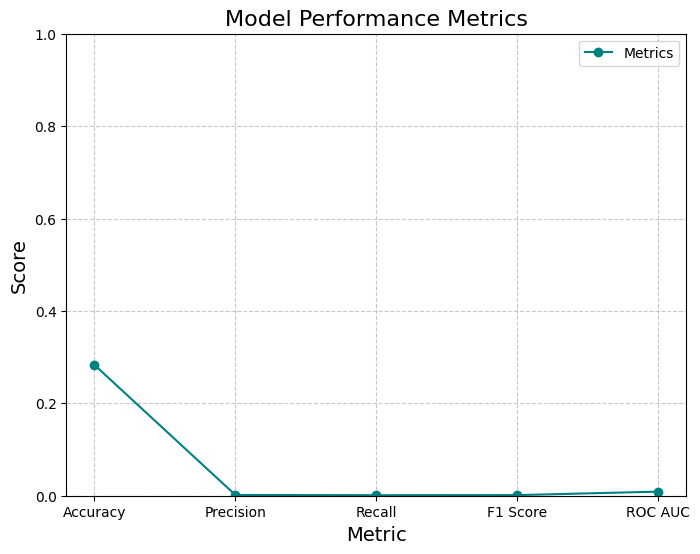

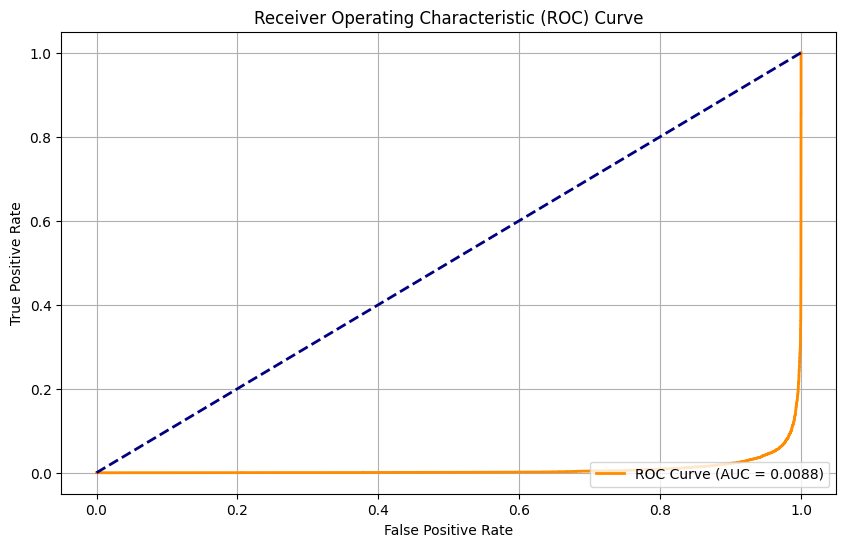

In [19]:
# Bar plot for metrics
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Line plot
plt.figure(figsize=(8, 6))
plt.plot(metric_names, metric_values, marker='o', linestyle='-', color='teal', label='Metrics')
plt.ylim(0, 1)  # Metrics are between 0 and 1
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Model Performance Metrics', fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()
# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute AUC

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Test the EfficientNet.

In [20]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load the image from the given path
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        
        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

In [32]:
# Load pre-trained EfficientNet-B0 (It is possible to change to B1, B2, etc., if desired) 
# B0 is the smallest and fastest, while B7 is the largest and most accurate.
model = models.efficientnet_b0(pretrained=True)

# Define the image transformations for EfficientNet
efficientnet_transform = transforms.Compose([
    transforms.Resize(256),  # Resize images to 256px
    transforms.CenterCrop(224),  # Crop the center 224x224 part
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

C:\Users\nefel\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nefel\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# Create the combined dataset
dataset_ = CustomImageDataset(image_paths=all_image_paths, labels=all_labels, transform=transform)
test_dataset1 = dataset_

In [31]:
from torch.utils.data import DataLoader

# Create DataLoaders for each dataset split
test_loader = DataLoader(test_dataset1, batch_size=64, shuffle=False)

In [33]:
# Define the number of classes in your dataset
NUM_CLASSES = 2  # Real vs Fake
IMG_SIZE = 224

# Load the pre-trained EfficientNetB0
def build_model(num_classes):
    # Use the weights parameter instead of pretrained=True
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Specify the desired weights
    model = efficientnet_b0(weights=weights)

    # Freeze the pre-trained layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Ensure top layers are trainable
    # for param in model.classifier.parameters():  # Adjust based on your model's architecture
    #     param.requires_grad = True

    # Replace the classifier with a custom one
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),  # Regularization
        nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust output for num_classes
    )

    return model

In [37]:
from sklearn.metrics import confusion_matrix
def test_model(model, test_loader):
    '''
    Function to test a model on a test dataset.
    '''
    model.eval()
    test_predictions, test_true_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(test_true_labels, test_predictions)
    precision = precision_score(test_true_labels, test_predictions)
    recall = recall_score(test_true_labels, test_predictions)
    f1 = f1_score(test_true_labels, test_predictions)
    roc_auc = roc_auc_score(test_true_labels, test_predictions)

    print('\nTest Results')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Test ROC AUC: {roc_auc:.4f}')

    test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)
    print("\nConfusion Matrix:\n", test_conf_matrix)

    return {
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_roc_auc': roc_auc,
        'confusion_matrix': test_conf_matrix,
    }


In [38]:
test_results = test_model(model, test_loader)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].